In [1]:
import os

import numpy as np
import pandas
#import seaborn as sns

from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

kf = KFold(n_splits=5, shuffle=True, random_state=421)

import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
def load_data_for_kaggle(data_path='DATA'):
    
    data_train = pandas.read_csv(os.path.join(data_path, 'train.csv'))
    data_test = pandas.read_csv(os.path.join(data_path, 'test.csv'))

    X_train = data_train.drop('Survived', axis=1)
    y_train = data_train['Survived'].values
    X_test = data_test
    
    return (X_train, y_train, X_test)

In [3]:
(X_train, y_train, X_test) = load_data_for_kaggle()

In [3]:
def load_data_for_test(data_path='DATA', train_size=0.8):
   
    data = pandas.read_csv(os.path.join(data_path, 'train.csv'))

    X = data.drop('Survived', axis=1)
    y = data['Survived'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    return (X_train, X_test, y_train, y_test, X, y)

In [26]:
(X_train, X_test, y_train, y_test, X, y) = load_data_for_test()

## Exploring the Data

In [71]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [43]:
data['Died'] = np.zeros(data.shape[0], dtype=np.uint8)

In [44]:
data.loc[data.Survived == 0, ['Died']] = 1

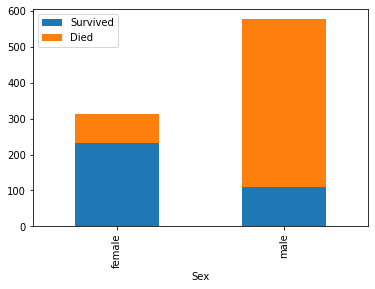

In [45]:
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked=True)

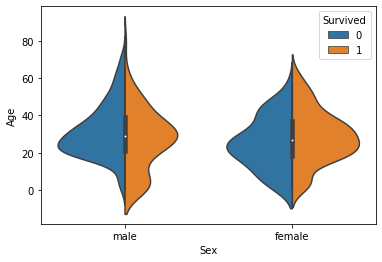

In [46]:
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True)

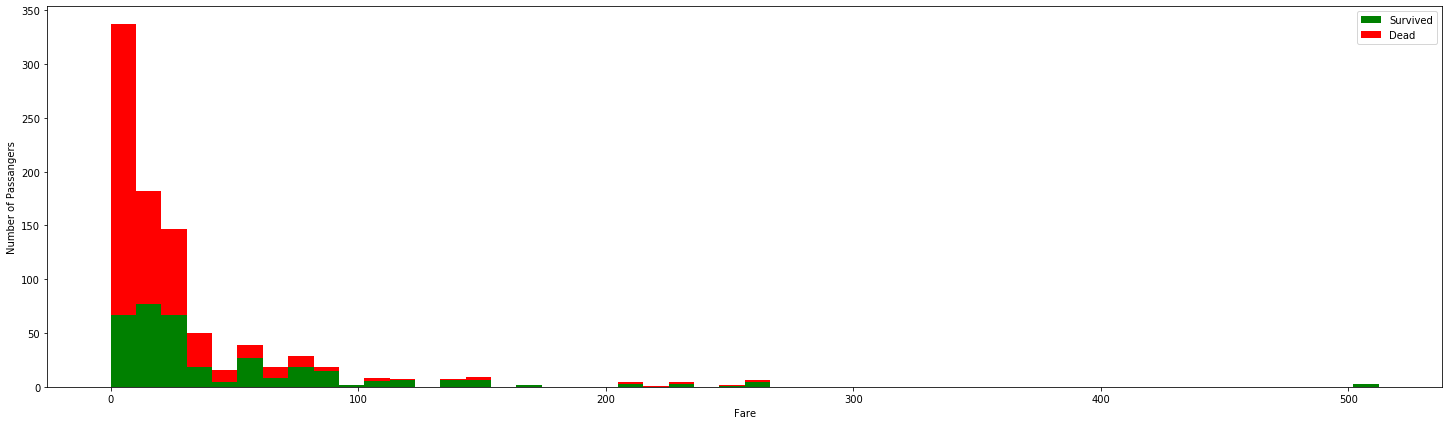

In [47]:
plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']],
        stacked=True, color=['g', 'r'],
        bins=50, label=['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passangers')
plt.legend()

Text(0, 0.5, 'Fare')

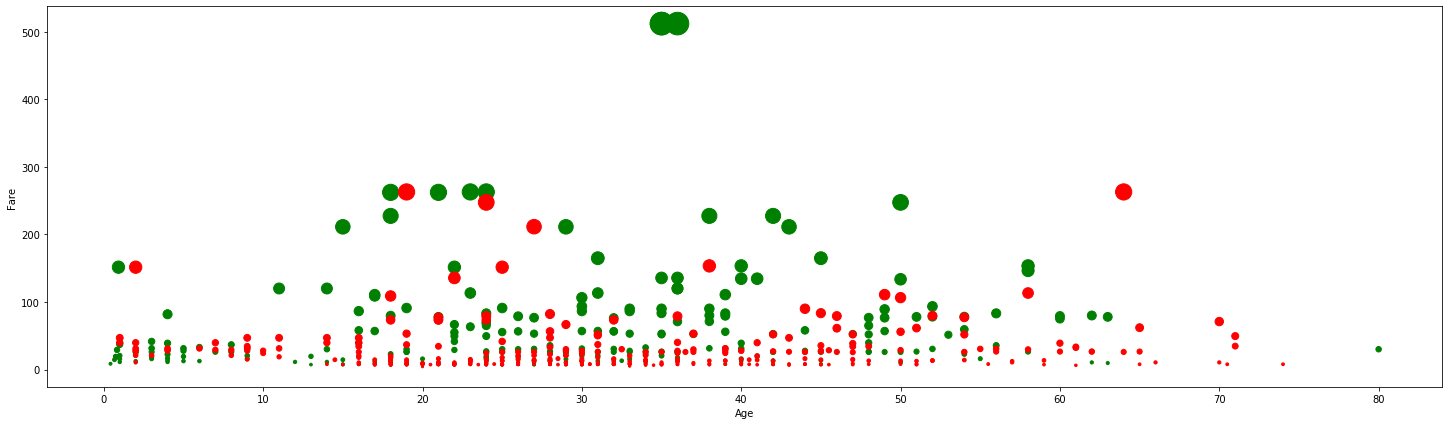

In [48]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'],
          c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'],
          c='red', s=data[data['Survived'] == 0]['Fare'])
plt.xlabel('Age')
plt.ylabel('Fare')

## Preprocessing the Data

In [5]:
class FamilyTransform(TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['FamilySize'] = X['Parch'] + X['SibSp'] + 1

        X['Singleton'] = X['FamilySize'].map(lambda s: 1 if s == 1 else 0)
        X['SmallFamily'] = X['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
        X['BigFamily'] = X['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
        
        #X.drop(['Parch', 'SibSp'], axis=1, inplace=True)
        
        return X
    

def process_family(data):
    
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1

    data['Singleton'] = data['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    data['SmallFamily'] = data['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    data['BigFamily'] = data['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    data.drop(['Parch', 'SibSp'], axis=1, inplace=True)
    
    return data

In [6]:
class EmbarkedTransform(TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['Embarked'].fillna('S', inplace=True)

        embarked_dummies = pandas.get_dummies(X['Embarked'], prefix='Embarked')
        X = pandas.concat([X, embarked_dummies], axis=1)
        X.drop('Embarked', axis=1, inplace=True)
        
        return X

def process_embarked(data):

    data['Embarked'].fillna('S', inplace=True)
    
    data_dummies = pandas.get_dummies(data['Embarked'], prefix='Embarked')
    data = pandas.concat([data, data_dummies], axis=1)
    data.drop('Embarked', axis=1, inplace=True)
    
    return data

In [7]:
class CabinTransform(TransformerMixin):
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        
        X['Cabin'].fillna('U', inplace=True)
        X['Cabin'] = X['Cabin'].map(lambda c: c[0])

        cabin_dummies = pandas.get_dummies(X['Cabin'], prefix='Cabin')
        X = pandas.concat([X, cabin_dummies], axis=1)

        X.drop('Cabin', axis=1, inplace=True)
        
        return X

def process_cabin(data):
    
    data['Cabin'].fillna('U', inplace=True)
    data['Cabin'] = data['Cabin'].map(lambda c: c[0])
    
    data_dummies = pandas.get_dummies(data['Cabin'], prefix='Cabin')
    data = pandas.concat([data, data_dummies], axis=1)
    
    data.drop('Cabin', axis=1, inplace=True)
    
    return data

In [8]:
titles_dictionary = {
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Jonkheer': 'Royalty',
    'Don': 'Royalty',
    'Sir': 'Royalty',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'the Countess': 'Royalty',
    'Mme': 'Mr',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Lady': 'Royalty',
}

class TitleTransform(TransformerMixin):

    def fit(self, X, y=None):
        
        self.titles = ['Title_{}'.format(s) for s in list(set(titles_dictionary.values()))]
        
        return self
    
    def transform(self, X, y=None):
        
        X['Title'] = X['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
        X['Title'] = X.Title.map(titles_dictionary)
        

        return X

def process_titles(data):
    
    data['Title'] = data['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    data['Title'] = data.Title.map(titles_dictionary)
    
    return data

In [ ]:
grouped_data = X_train.groupby(['Sex', 'Pclass', 'Title'])
grouped_median_train = grouped_data.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train.head()

In [10]:
class AgeTransform(TransformerMixin):

    def fit(self, X, y=None):
        grouped_data = X.groupby(['Sex', 'Pclass', 'Title'])
        self.grouped_median_age = grouped_data.median()
        self.grouped_median_age = self.grouped_median_age.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
        
        return self
        
    def transform(self, X, y=None):
        
        X['Age'] = X.apply(lambda row: self._fill_age_(row) if np.isnan(row['Age']) else row['Age'], axis=1)

        return X
    
    def _fill_age_(self, row):
        condition = (
            (self.grouped_median_age['Sex'] == row['Sex']) &
            (self.grouped_median_age['Pclass'] == row['Pclass']) &
            (self.grouped_median_age['Title'] == row['Title'])
        )
        if np.isnan(self.grouped_median_age[condition]['Age'].values[0]):
            condition = (
                (self.grouped_median_age['Sex'] == row['Sex']) &
                (self.grouped_median_age['Pclass'] == row['Pclass'])
            )

        return self.grouped_median_age[condition]['Age'].values[0]
        

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) &
        (grouped_median_train['Pclass'] == row['Pclass']) &
        (grouped_median_train['Title'] == row['Title'])
    )
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) &
            (grouped_median_train['Pclass'] == row['Pclass'])
        )
        
    return grouped_median_train[condition]['Age'].values[0]

def process_age(data):
    
    data['Age'] = data.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    
    return data

In [11]:
class NameTransform(TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X.drop('Name', axis=1, inplace=True)
    
        titles_dummies = pandas.get_dummies(X['Title'], prefix='Title')
        X = pandas.concat([X, titles_dummies], axis=1)
        X.drop('Title', axis=1, inplace=True)

        return X

def proccess_name(data):
    
    data.drop('Name', axis=1, inplace=True)
    
    titles_dummies = pandas.get_dummies(data['Title'], prefix='Title')
    data = pandas.concat([data, titles_dummies], axis=1)
    data.drop('Title', axis=1, inplace=True)
    
    return data

In [22]:
class BinaryTransform(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['Sex'] = X['Sex'].map(lambda sex: 1 if sex == 'male' else 0)
        
        return X

In [ ]:
class DroppingTranform(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Parameters that have the biggest weights, while others can be ignored
        important_cols = ['Title_Mr', 'Sex', 'Ticket', 'Fare', 'PassengerId', \
                          'Age', 'Pclass', 'FamilySize', 'Cabin_T', 'BigFamily', \
                          'Title_Miss', 'SibSp', 'Title_Officer']
    
        df = pandas.DataFrame()
        for col in important_cols:
            df[col] = X[col]
            
        return df

In [23]:
preprocess_pipeline = Pipeline(steps=[
    ('family', FamilyTransform()),
    ('embarked', EmbarkedTransform()),
    ('cabin', CabinTransform()),
    ('title', TitleTransform()),
    ('age', AgeTransform()),
    ('name', NameTransform()),
    ('binary', BinaryTransform()),
    ('drop', DroppingTransform()),
])

In [14]:
(X_train, y_train, X_test) = load_data_for_kaggle()

In [28]:
X = pandas.concat([X_train, X_test], axis=0)

In [29]:
X = preprocess_pipeline.fit_transform(X)

In [16]:
X_train = X[:891]
X_test = X[891:]

In [18]:
X_train.head()

Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  Singleton  \
0       3    1  22.0      1      0   7.2500           2          0   
1       1    0  38.0      1      0  71.2833           2          0   
2       3    0  26.0      0      0   7.9250           1          1   
3       1    0  35.0      1      0  53.1000           2          0   
4       3    1  35.0      0      0   8.0500           1          1   

   SmallFamily  BigFamily      ...        Cabin_F  Cabin_G  Cabin_T  Cabin_U  \
0            1          0      ...              0        0        0        1   
1            1          0      ...              0        0        0        0   
2            0          0      ...              0        0        0        1   
3            1          0      ...              0        0        0        0   
4            0          0      ...              0        0        0        1   

   Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Officer  Title_Royalty  
0             0           0         1          0              0              0  
1             0           0         0          1              0              0  
2             0           1         0          0              0              0  
3             0           0         0          1              0              0  
4             0           0         1          0              0              0  

[5 rows x 28 columns]

## SVC

In [134]:
param_grid = {'C':np.linspace(1.0, 10.0, num=200), 'degree':np.arange(1, 5)}

In [135]:
grid = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid, verbose=5)

In [136]:
grid.fit(X_train, y_train)

/anaconda3/envs/python-cvcourse/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 800 candidates, totalling 2400 fits
[CV] C=1.0, degree=1 .................................................
[CV] ..................... C=1.0, degree=1, score=0.774, total=   0.0s
[CV] C=1.0, degree=1 .................................................
[CV] ..................... C=1.0, degree=1, score=0.805, total=   0.0s
[CV] C=1.0, degree=1 .................................................
[CV] ..................... C=1.0, degree=1, score=0.788, total=   0.0s
[CV] C=1.0, degree=2 .................................................
[CV] ..................... C=1.0, degree=2, score=0.774, total=   0.0s
[CV] C=1.0, degree=2 .................................................
[CV] ..................... C=1.0, degree=2, score=0.805, total=   0.0s
[CV] C=1.0, degree=2 .................................................
[CV] ..................... C=1.0, degree=2, score=0.788, total=   0.0s
[CV] C=1.0, degree=3 .................................................
[CV] ........

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   22.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([ 1.        ,  1.04522613,  1.09045226,  1.135678...
        8.91457286,  8.95979899,  9.00502513,  9.05025126,  9.09547739,
        9.14070352,  9.18592965,  9.23115578,  9.27638191,  9.32160804,
        9.36683417,  9.4120603 ,  9.45728643,  9.50251256,  9.54773869,
        9.59296482,  9.63819095,  9.68341709,  9.72864322,  9.77386935,
        9.81909548,  9.86432161,  9.90954774,  9.95477387, 10.        ]),
                         'degree': array([1, 2, 3, 4])},
             pre_dispatch='2*n_jobs', refit=Tr

In [137]:
grid.best_params_

{'C': 8.869346733668342, 'degree': 1}

In [194]:
clf = SVC(kernel='rbf', gamma='auto', C=8.869346733668342, degree=1)

In [195]:
clf.fit(X_train, y_train)

SVC(C=8.869346733668342, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [196]:
cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy').mean()

0.7444105190584064

In [197]:
y_pred_svc = clf.predict(X_test)

In [ ]:
scv_result = accuracy_score(y_test, y_pred_svc)
scv_result

## Logistic Regression

In [577]:
clf = LogisticRegression(solver='lbfgs')

In [578]:
clf.fit(X_train, y_train)

/anaconda3/envs/fucked-up-data-science/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [579]:
cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy').mean()

/anaconda3/envs/fucked-up-data-science/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/fucked-up-data-science/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/fucked-up-data-science/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/fucked-up-data-science/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/fucked-up-data-science/lib/python3.7/site-packages/sklearn/linear_model/logistic

0.8260561170045821

In [580]:
y_pred_log_reg = clf.predict(X_test)

In [118]:
log_reg_result = accuracy_score(y_test, y_pred_log_reg)
log_reg_result

0.7757847533632287

## Random Forest

In [4]:
param_grid = {'n_estimators':np.arange(10, 100),'max_depth':np.arange(1, 10)}

In [7]:
grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=2)

In [11]:
grid.fit(X_train, y_train)

/anaconda3/envs/python-cvcourse/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=12 ....................................
[CV] ........

[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:  1.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...
                         'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35,

In [12]:
grid.best_params_

{'max_depth': 6, 'n_estimators': 28}

In [ ]:
# n_estimators=180, min_samples_leaf=3, max_features=0.5, n_jobs=-1

In [39]:
clf = RandomForestClassifier(n_estimators=180, min_samples_leaf=3, max_features=0.5, n_jobs=-1)

In [40]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [41]:
cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy').mean()

0.8305442219571904

## Decision Tree

In [569]:
clf = DecisionTreeClassifier()

In [570]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [571]:
cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy').mean()

0.7856192329420627

In [572]:
y_pred_dec_tree = clf.predict(X_test)

In [ ]:
dec_tree_result = accuracy_score(y_test, y_pred_dec_tree)
dec_tree_result

In [76]:
y_pred[4] = 1

In [77]:
df_output = pandas.read_csv(os.path.join('DATA', 'gender_submission.csv'))
df_output['Survived'] = y_pred

In [78]:
df_output.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [79]:
df_output.to_csv('submission.csv', index=False)